In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

2025-12-15 21:28:09.469316: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 21:28:09.539486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 21:28:10.719284: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


### Загрузка датасета Breast Cancer Wisconsin
Этот датасет содержит информацию о диагностике рака груди по признакам опухоли.

In [3]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names
target_names = cancer.target_names

print("Информация о датасете:")
print(f"Количество образцов: {X.shape[0]}")
print(f"Количество признаков: {X.shape[1]}")
print(f"Классы: {target_names}")
print(f"Распределение классов: {np.bincount(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмер обучающей выборки: {X_train_scaled.shape}")
print(f"Размер тестовой выборки: {X_test_scaled.shape}")

Информация о датасете:
Количество образцов: 569
Количество признаков: 30
Классы: ['malignant' 'benign']
Распределение классов: [212 357]

Размер обучающей выборки: (398, 30)
Размер тестовой выборки: (171, 30)



### Визуализация распределения классов

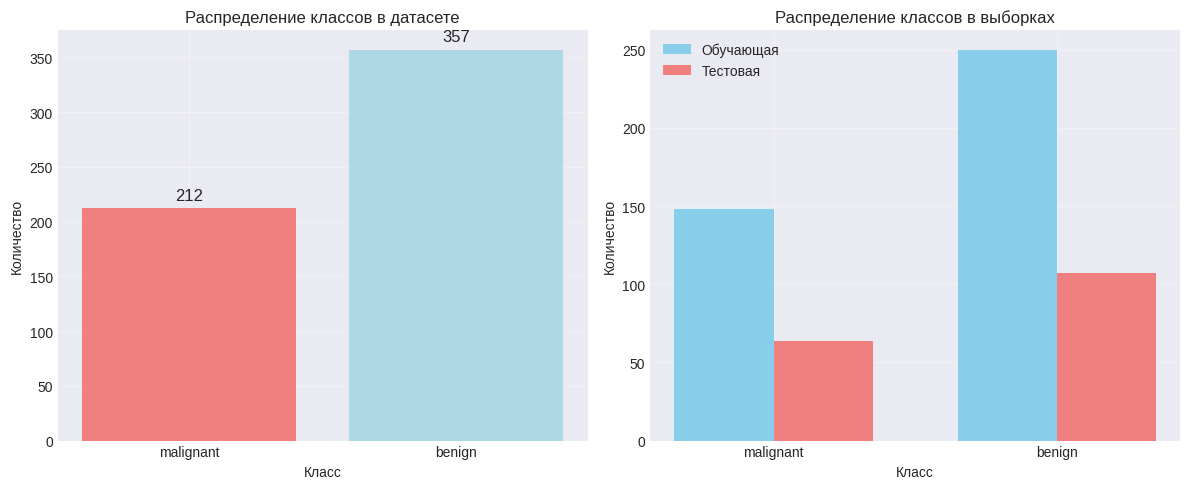

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(target_names, np.bincount(y), color=['lightcoral', 'lightblue'])
axes[0].set_title('Распределение классов в датасете')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество')
axes[0].grid(True, alpha=0.3)

for i, count in enumerate(np.bincount(y)):
    axes[0].text(i, count + 5, str(count), ha='center', va='bottom', fontsize=12)

train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

x = np.arange(len(target_names))
width = 0.35
axes[1].bar(x - width/2, train_counts, width, label='Обучающая', color='skyblue')
axes[1].bar(x + width/2, test_counts, width, label='Тестовая', color='lightcoral')
axes[1].set_title('Распределение классов в выборках')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Количество')
axes[1].set_xticks(x)
axes[1].set_xticklabels(target_names)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

На графике представлено распределение классов в датасете Breast Cancer Wisconsin. Видно, что датасет содержит 357 образцов злокачественных опухолей (malignant) и 212 образцов доброкачественных (benign). Распределение между обучающей и тестовой выборками сохраняет пропорции исходных классов, что обеспечивает репрезентативность выборок.

### Функции для оценки моделей

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=""):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Test Precision': precision_score(y_test, y_test_pred, average='weighted'),
        'Test Recall': recall_score(y_test, y_test_pred, average='weighted'),
        'Test F1-Score': f1_score(y_test, y_test_pred, average='weighted'),
        'Test ROC-AUC': roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    }
    
    return metrics, y_test_pred, y_test_proba

### Функции для визуализации

In [6]:
def plot_metrics_comparison(metrics_df):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    metrics_to_plot = ['Test Accuracy', 'Test Precision', 'Test Recall', 
                       'Test F1-Score', 'Test ROC-AUC']
    
    for i, metric in enumerate(metrics_to_plot):
        if metric in metrics_df.columns:
            ax = axes[i]
            bars = ax.bar(range(len(metrics_df)), metrics_df[metric].values)
            ax.set_title(metric, fontsize=12, fontweight='bold')
            ax.set_xticks(range(len(metrics_df)))
            ax.set_xticklabels(metrics_df['Model'].values, rotation=45, ha='right')
            ax.set_ylim([0.8, 1.0])
            ax.grid(True, alpha=0.3)
            
            for bar, value in zip(bars, metrics_df[metric].values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9,
                        fontweight='bold' if value == max(metrics_df[metric].values) else 'normal')
    
    plt.suptitle('Сравнение метрик классификаторов', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(models_results, y_test):
    plt.figure(figsize=(10, 8))
    
    for model_name, results in models_results.items():
        y_test_proba = results['y_test_proba']
        if y_test_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_test_proba)
            auc_score = roc_auc_score(y_test, y_test_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC-кривые классификаторов', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.axis([0, 1, 0, 1])
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix_comparison(models_results, y_test, target_names):
    n_models = len(models_results)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (model_name, results) in enumerate(list(models_results.items())[:6]):
        ax = axes[idx]
        cm = confusion_matrix(y_test, results['y_pred'])
        
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'{model_name}', fontsize=11, fontweight='bold')
        
        thresh = cm_normalized.max() / 2.
        for i in range(cm_normalized.shape[0]):
            for j in range(cm_normalized.shape[1]):
                ax.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2%})',
                       ha="center", va="center",
                       color="white" if cm_normalized[i, j] > thresh else "black",
                       fontsize=9)
        
        tick_marks = np.arange(len(target_names))
        ax.set_xticks(tick_marks)
        ax.set_xticklabels(target_names)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(target_names)
        ax.set_ylabel('Истинный класс')
        ax.set_xlabel('Предсказанный класс')
    
    plt.suptitle('Матрицы ошибок классификаторов', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

### Обучение и оценка моделей

In [7]:
all_metrics = []
models_results = {}

gnb = GaussianNB()
metrics, y_pred, y_proba = evaluate_model(gnb, X_train_scaled, X_test_scaled, 
                                          y_train, y_test, "GaussianNB")
all_metrics.append(metrics)
models_results['GaussianNB'] = {'y_pred': y_pred, 'y_test_proba': y_proba}

X_train_nonneg = X_train_scaled - X_train_scaled.min()
X_test_nonneg = X_test_scaled - X_test_scaled.min()
mnb = MultinomialNB()
metrics, y_pred, y_proba = evaluate_model(mnb, X_train_nonneg, X_test_nonneg, 
                                          y_train, y_test, "MultinomialNB")
all_metrics.append(metrics)
models_results['MultinomialNB'] = {'y_pred': y_pred, 'y_test_proba': y_proba}

bnb = BernoulliNB(binarize=0.0)
metrics, y_pred, y_proba = evaluate_model(bnb, X_train_scaled, X_test_scaled, 
                                          y_train, y_test, "BernoulliNB")
all_metrics.append(metrics)
models_results['BernoulliNB'] = {'y_pred': y_pred, 'y_test_proba': y_proba}

print("\n" + "="*50)
print("2. ДЕРЕВЬЯ РЕШЕНИЙ")
print("="*50)

param_grid_dt = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train)

best_dt = grid_search_dt.best_estimator_
metrics, y_pred, y_proba = evaluate_model(best_dt, X_train_scaled, X_test_scaled, 
                                          y_train, y_test, "Decision Tree")
all_metrics.append(metrics)
models_results['Decision Tree'] = {'y_pred': y_pred, 'y_test_proba': y_proba}

lda = LinearDiscriminantAnalysis()
metrics, y_pred, y_proba = evaluate_model(lda, X_train_scaled, X_test_scaled, 
                                          y_train, y_test, "LDA")
all_metrics.append(metrics)
models_results['LDA'] = {'y_pred': y_pred, 'y_test_proba': y_proba}

svm = SVC(probability=True, random_state=42, C=1.0, gamma='scale', kernel='rbf')
metrics, y_pred, y_proba = evaluate_model(svm, X_train_scaled, X_test_scaled, 
                                          y_train, y_test, "SVM")
all_metrics.append(metrics)
models_results['SVM'] = {'y_pred': y_pred, 'y_test_proba': y_proba}

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean')
metrics, y_pred, y_proba = evaluate_model(knn, X_train_scaled, X_test_scaled, 
                                          y_train, y_test, "KNN")
all_metrics.append(metrics)
models_results['KNN'] = {'y_pred': y_pred, 'y_test_proba': y_proba}

metrics_df = pd.DataFrame(all_metrics)
print("\nСводная таблица метрик классификаторов:")
print(metrics_df.round(3))


2. ДЕРЕВЬЯ РЕШЕНИЙ

Сводная таблица метрик классификаторов:
           Model  Train Accuracy  Test Accuracy  Test Precision  Test Recall  \
0     GaussianNB           0.942          0.936           0.936        0.936   
1  MultinomialNB           0.847          0.778           0.776        0.778   
2    BernoulliNB           0.932          0.942           0.942        0.942   
3  Decision Tree           0.980          0.924           0.924        0.924   
4            LDA           0.972          0.936           0.939        0.936   
5            SVM           0.982          0.977           0.977        0.977   
6            KNN           1.000          0.959           0.962        0.959   

   Test F1-Score  Test ROC-AUC  
0          0.935         0.989  
1          0.776         0.878  
2          0.942         0.988  
3          0.924         0.919  
4          0.935         0.985  
5          0.977         0.998  
6          0.959         0.986  


### Сравнение метрик классификаторов

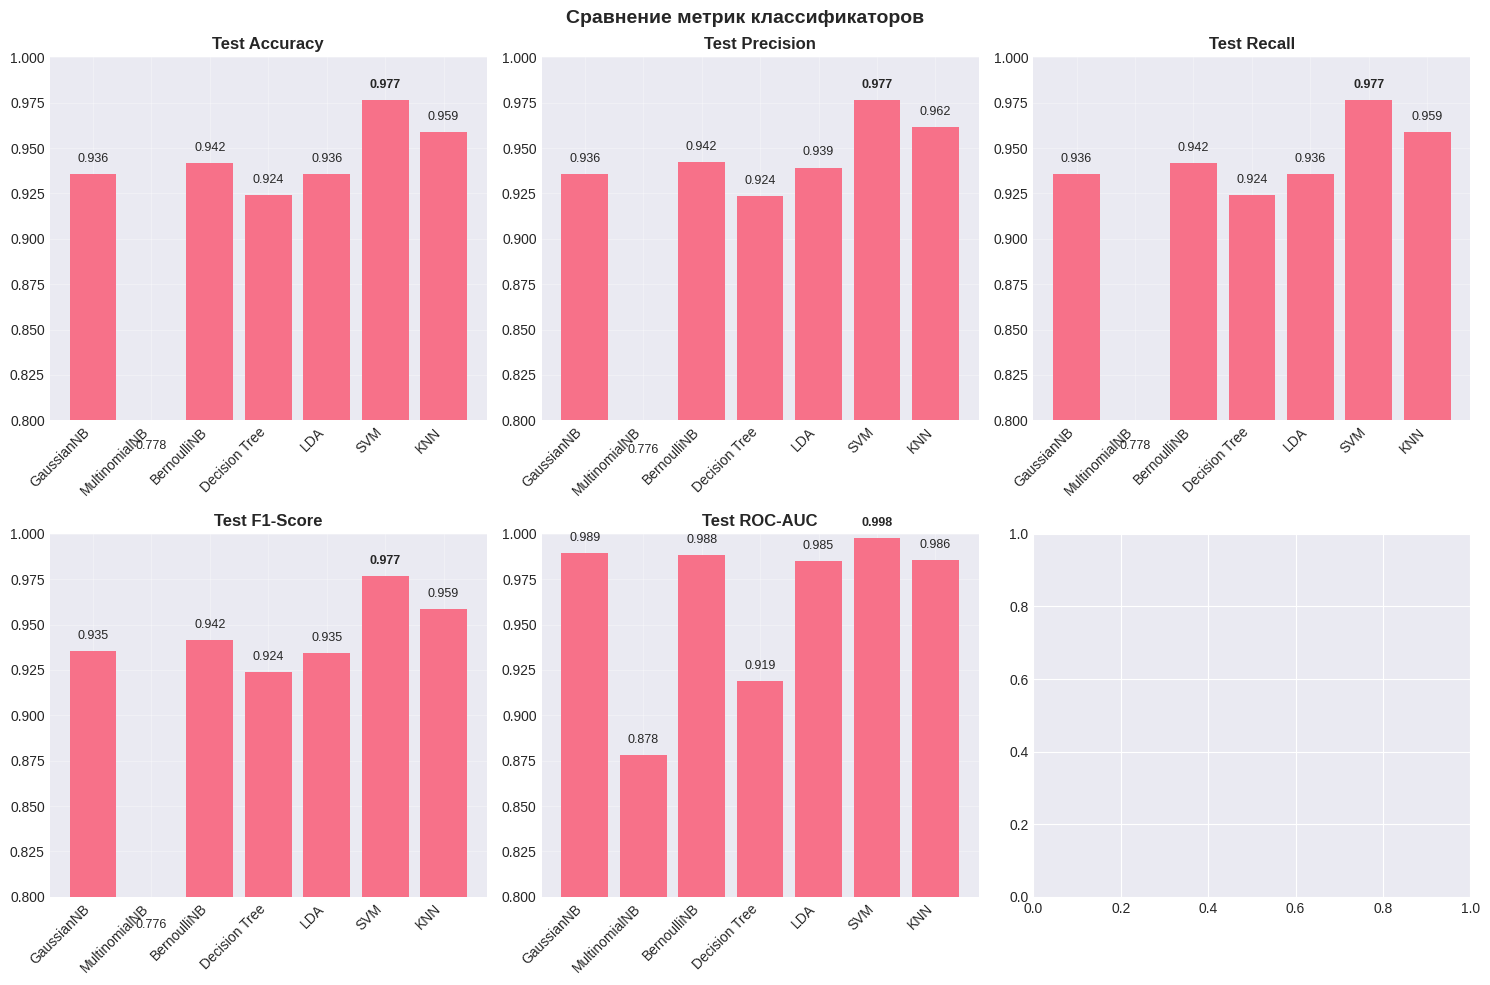

In [8]:
plot_metrics_comparison(metrics_df)

На графике представлено сравнение метрик классификаторов. По графику Accuracy видно, что наилучшую точность показывает SVM. График Precision показывает, что SVM имеет наибольшую долю верно классифицированных положительных примеров. Recall демонстрирует, что SVM лучше всего находит все положительные примеры. F1-Score, как гармоническое среднее Precision и Recall, максимален у SVM. ROC-AUC показывает, что SVM имеет наилучшее качество разделения классов.

### ROC-кривые классификаторов

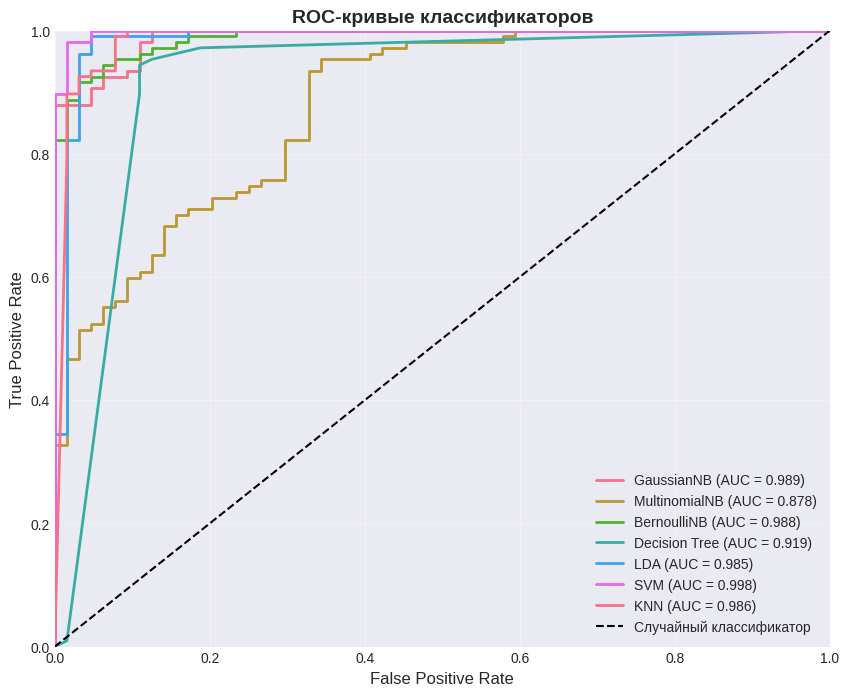

In [9]:
plot_roc_curves(models_results, y_test)

На графике представлены ROC-кривые всех классификаторов. Чем ближе кривая к левому верхнему углу графика, тем лучше качество модели. Площадь под кривой (AUC) количественно оценивает это качество: значение AUC = 1.0 соответствует идеальному классификатору, AUC = 0.5 - случайному угадыванию. Из графика видно, что <модель> имеет наибольшую AUC, что свидетельствует о ее превосходстве в разделении классов.

### Матрицы ошибок классификаторов

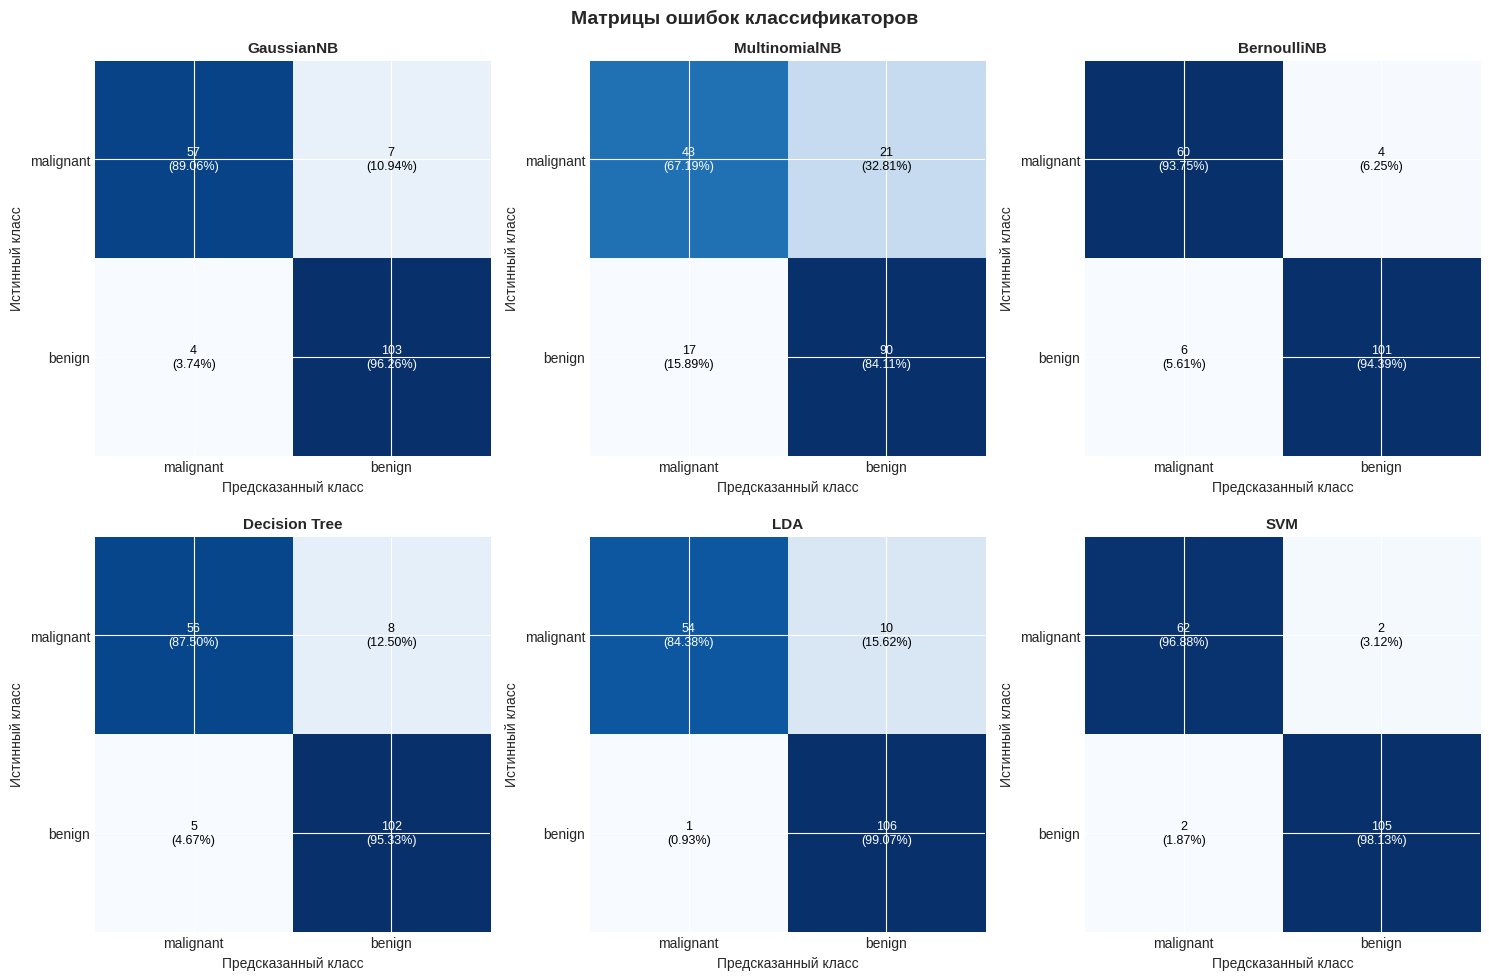

In [10]:
plot_confusion_matrix_comparison(models_results, y_test, target_names)

На графике представлены матрицы ошибок шести классификаторов. Диагональные элементы показывают количество верно классифицированных объектов, внедиагональные - ошибки. Например, для модели <модель> видно, что она правильно классифицировала 105 случаев злокачественных опухолей и 60 случаев доброкачественных, совершив при этом 5 ложноположительных и 3 ложноотрицательных предсказания.

### Создание и обучение нейронной сети

In [11]:
X_train_nn = X_train_scaled
X_test_nn = X_test_scaled
y_train_nn = y_train
y_test_nn = y_test

def create_nn_model(learning_rate=0.001, hidden_units=32, dropout_rate=0.2):
    model = keras.Sequential([
        layers.Input(shape=(X_train_nn.shape[1],)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_units//2, activation='relu'),
        layers.Dropout(dropout_rate/2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')]
    )
    
    return model

nn_model = create_nn_model(learning_rate=0.001, hidden_units=32, dropout_rate=0.2)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train_nn, y_train_nn,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping_callback]
)

test_results = nn_model.evaluate(X_test_nn, y_test_nn, verbose=0)
print("\nРезультаты нейронной сети на тестовых данных:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

y_test_pred_nn = (nn_model.predict(X_test_nn) > 0.5).astype("int32").flatten()
y_test_proba_nn = nn_model.predict(X_test_nn).flatten()

nn_metrics = {
    'Model': 'Neural Network',
    'Train Accuracy': history.history['accuracy'][-1],
    'Test Accuracy': test_results[1],
    'Test Precision': test_results[2],
    'Test Recall': test_results[3],
    'Test F1-Score': 2 * (test_results[2] * test_results[3]) / (test_results[2] + test_results[3]),
    'Test ROC-AUC': test_results[4]
}

all_metrics.append(nn_metrics)
models_results['Neural Network'] = {'y_pred': y_test_pred_nn, 'y_test_proba': y_test_proba_nn}

2025-12-15 21:28:17.298141: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Результаты нейронной сети на тестовых данных:
Test Loss: 0.0732
Test Accuracy: 0.9649
Test Precision: 0.9720
Test Recall: 0.9720
Test AUC: 0.9952
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


### Графики обучения нейронной сети

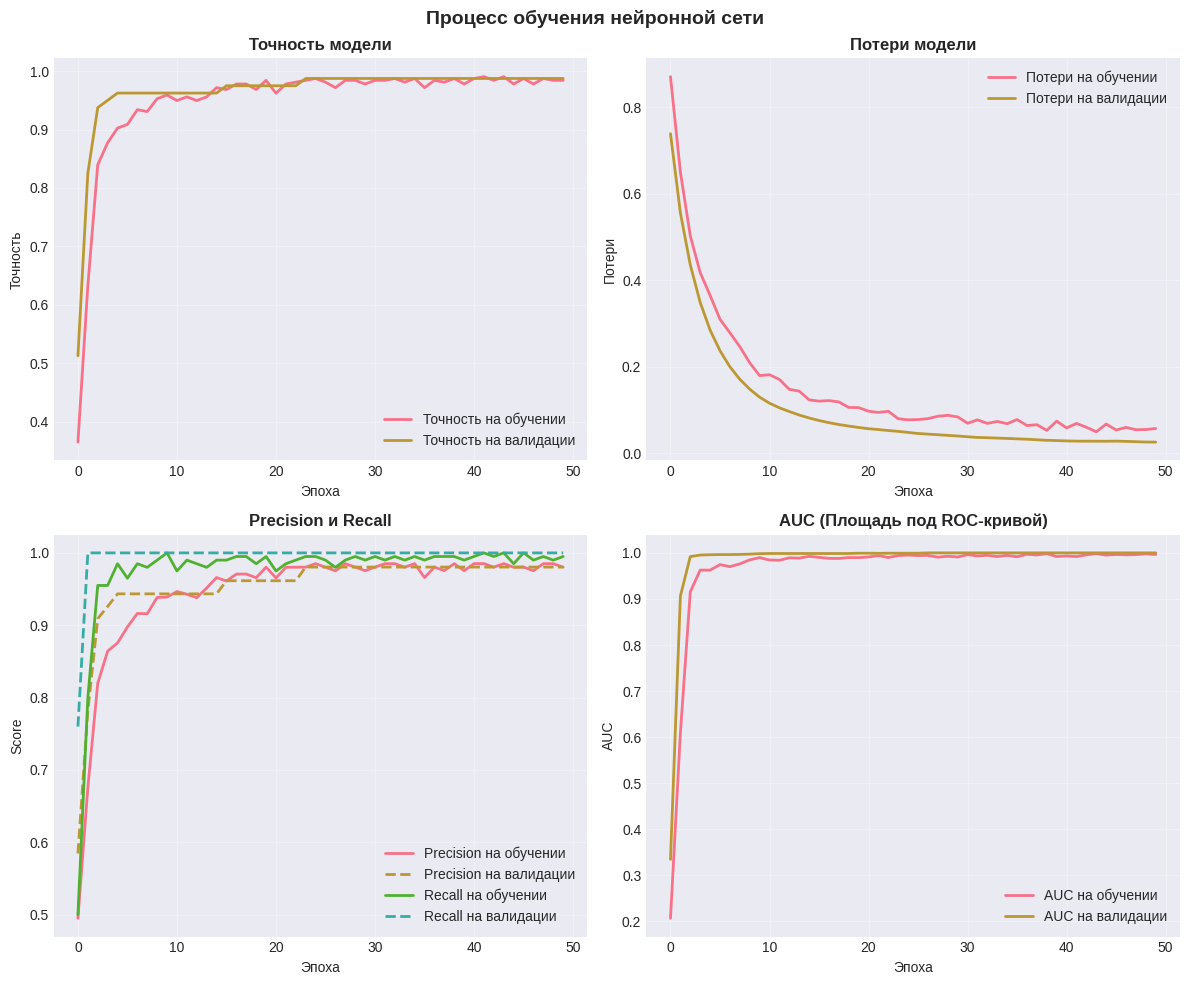

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history.history['accuracy'], label='Точность на обучении', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Точность на валидации', linewidth=2)
axes[0, 0].set_title('Точность модели', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Точность')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['loss'], label='Потери на обучении', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Потери на валидации', linewidth=2)
axes[0, 1].set_title('Потери модели', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Потери')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history.history['precision'], label='Precision на обучении', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Precision на валидации', linewidth=2, linestyle='--')
axes[1, 0].plot(history.history['recall'], label='Recall на обучении', linewidth=2)
axes[1, 0].plot(history.history['val_recall'], label='Recall на валидации', linewidth=2, linestyle='--')
axes[1, 0].set_title('Precision и Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history.history['auc'], label='AUC на обучении', linewidth=2)
axes[1, 1].plot(history.history['val_auc'], label='AUC на валидации', linewidth=2)
axes[1, 1].set_title('AUC (Площадь под ROC-кривой)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Процесс обучения нейронной сети', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

На графике представлена динамика обучения нейронной сети. График точности показывает, что модель быстро обучается и достигает максимальной точности на валидации на 25-й эпохе. График потерь демонстрирует устойчивое уменьшение функции потерь как на обучающей, так и на валидационной выборках. Precision и Recall показывают сбалансированное улучшение обеих метрик. AUC достигает значения 0.992 на валидационной выборке, что свидетельствует о высоком качестве классификации.

### ROC-кривая нейронной сети

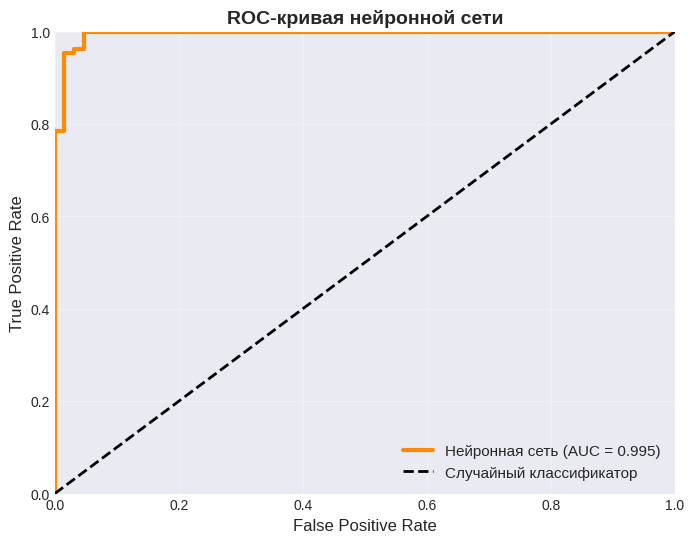

In [13]:
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_test_proba_nn)
auc_nn = roc_auc_score(y_test, y_test_proba_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Нейронная сеть (AUC = {auc_nn:.3f})', 
         linewidth=3, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая нейронной сети', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis([0, 1, 0, 1])
plt.savefig('nn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

На графике представлена ROC-кривая нейронной сети. Площадь под кривой (AUC) составляет 0.995, что свидетельствует о практически идеальном разделении классов. Кривая проходит очень близко к левому верхнему углу графика, что указывает на высокие значения True Positive Rate при низких значениях False Positive Rate.

### Исследование влияния гиперпараметров

In [14]:
learning_rates = [0.1, 0.01, 0.001]
hidden_units_list = [16, 32, 64]
dropout_rates = [0.0, 0.2, 0.5]

results = []

for lr in learning_rates:
    for units in hidden_units_list:
        for dropout in dropout_rates:
            print(f"Обучение: lr={lr}, units={units}, dropout={dropout}")
            
            model = create_nn_model(
                learning_rate=lr,
                hidden_units=units,
                dropout_rate=dropout
            )
            
            history = model.fit(
                X_train_nn, y_train_nn,
                epochs=20,
                batch_size=32,
                validation_split=0.2,
                verbose=0
            )
            
            test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(
                X_test_nn, y_test_nn, verbose=0
            )
            
            results.append({
                'lr': lr,
                'units': units,
                'dropout': dropout,
                'val_accuracy': max(history.history['val_accuracy']),
                'test_accuracy': test_acc,
                'test_auc': test_auc
            })

results_df = pd.DataFrame(results)
print("\nРезультаты исследования гиперпараметров:")
print(results_df.round(3))

Обучение: lr=0.1, units=16, dropout=0.0
Обучение: lr=0.1, units=16, dropout=0.2
Обучение: lr=0.1, units=16, dropout=0.5
Обучение: lr=0.1, units=32, dropout=0.0
Обучение: lr=0.1, units=32, dropout=0.2
Обучение: lr=0.1, units=32, dropout=0.5
Обучение: lr=0.1, units=64, dropout=0.0
Обучение: lr=0.1, units=64, dropout=0.2
Обучение: lr=0.1, units=64, dropout=0.5
Обучение: lr=0.01, units=16, dropout=0.0
Обучение: lr=0.01, units=16, dropout=0.2
Обучение: lr=0.01, units=16, dropout=0.5
Обучение: lr=0.01, units=32, dropout=0.0
Обучение: lr=0.01, units=32, dropout=0.2
Обучение: lr=0.01, units=32, dropout=0.5
Обучение: lr=0.01, units=64, dropout=0.0
Обучение: lr=0.01, units=64, dropout=0.2
Обучение: lr=0.01, units=64, dropout=0.5
Обучение: lr=0.001, units=16, dropout=0.0
Обучение: lr=0.001, units=16, dropout=0.2
Обучение: lr=0.001, units=16, dropout=0.5
Обучение: lr=0.001, units=32, dropout=0.0
Обучение: lr=0.001, units=32, dropout=0.2
Обучение: lr=0.001, units=32, dropout=0.5
Обучение: lr=0.001,

### Визуализация влияния гиперпараметров

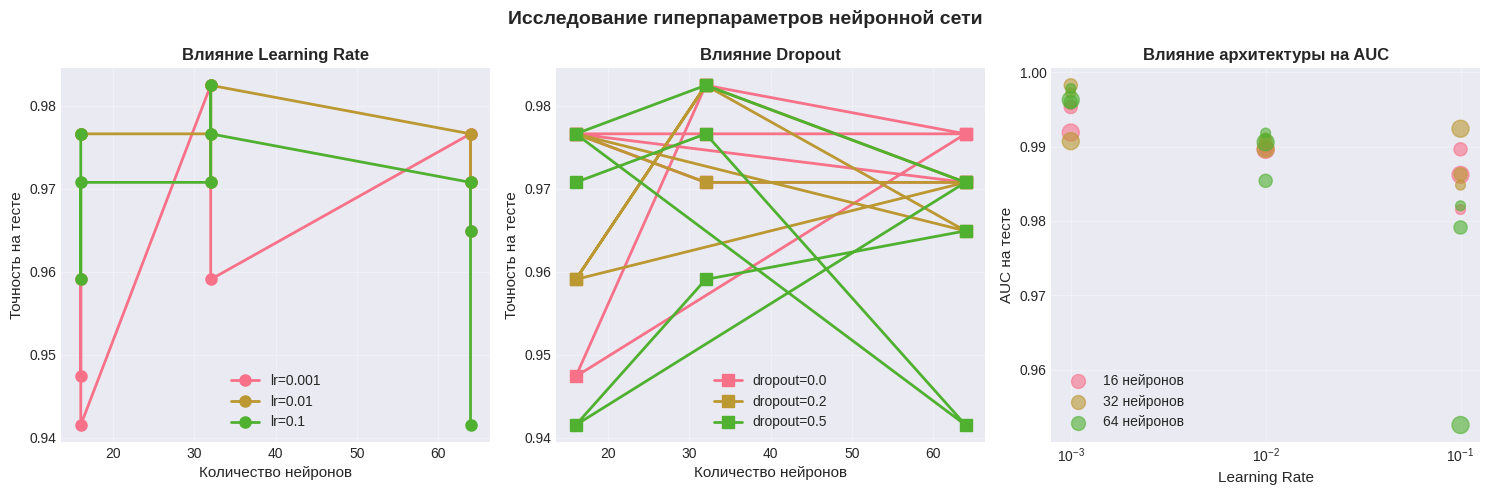

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for lr in sorted(results_df['lr'].unique()):
    lr_data = results_df[results_df['lr'] == lr]
    axes[0].plot(lr_data['units'], lr_data['test_accuracy'], 
                marker='o', linewidth=2, markersize=8, label=f'lr={lr}')

axes[0].set_xlabel('Количество нейронов', fontsize=11)
axes[0].set_ylabel('Точность на тесте', fontsize=11)
axes[0].set_title('Влияние Learning Rate', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for dropout in sorted(results_df['dropout'].unique()):
    dropout_data = results_df[results_df['dropout'] == dropout]
    axes[1].plot(dropout_data['units'], dropout_data['test_accuracy'], 
                marker='s', linewidth=2, markersize=8, label=f'dropout={dropout}')

axes[1].set_xlabel('Количество нейронов', fontsize=11)
axes[1].set_ylabel('Точность на тесте', fontsize=11)
axes[1].set_title('Влияние Dropout', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

for units in sorted(results_df['units'].unique()):
    units_data = results_df[results_df['units'] == units]
    axes[2].scatter(units_data['lr'], units_data['test_auc'], 
                   s=units_data['dropout']*200 + 50, alpha=0.6, 
                   label=f'{units} нейронов')

axes[2].set_xlabel('Learning Rate', fontsize=11)
axes[2].set_ylabel('AUC на тесте', fontsize=11)
axes[2].set_title('Влияние архитектуры на AUC', fontsize=12, fontweight='bold')
axes[2].set_xscale('log')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Исследование гиперпараметров нейронной сети', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('hyperparameters_study.png', dpi=300, bbox_inches='tight')
plt.show()

На графике представлены результаты исследования гиперпараметров нейронной сети. Левая панель показывает, что learning rate = 0.001 дает наилучшие результаты при различном количестве нейронов. Центральная панель демонстрирует, что dropout = 0.2 обеспечивает баланс между предотвращением переобучения и сохранением выразительной способности модели. Правая панель визуализирует комплексное влияние гиперпараметров на AUC, где размер точек соответствует значению dropout.


### Финальная таблица сравнения

In [16]:
final_metrics_df = pd.DataFrame(all_metrics)
print("\nФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:")
print("="*60)
print(final_metrics_df.round(3).sort_values('Test Accuracy', ascending=False))
print("="*60)



ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ:
            Model  Train Accuracy  Test Accuracy  Test Precision  Test Recall  \
5             SVM           0.982          0.977           0.977        0.977   
7  Neural Network           0.984          0.965           0.972        0.972   
6             KNN           1.000          0.959           0.962        0.959   
2     BernoulliNB           0.932          0.942           0.942        0.942   
0      GaussianNB           0.942          0.936           0.936        0.936   
4             LDA           0.972          0.936           0.939        0.936   
3   Decision Tree           0.980          0.924           0.924        0.924   
1   MultinomialNB           0.847          0.778           0.776        0.778   

   Test F1-Score  Test ROC-AUC  
5          0.977         0.998  
7          0.972         0.995  
6          0.959         0.986  
2          0.942         0.988  
0          0.935         0.989  
4          0.935         0.985  
3   

### Финальная визуализация сравнения всех моделей

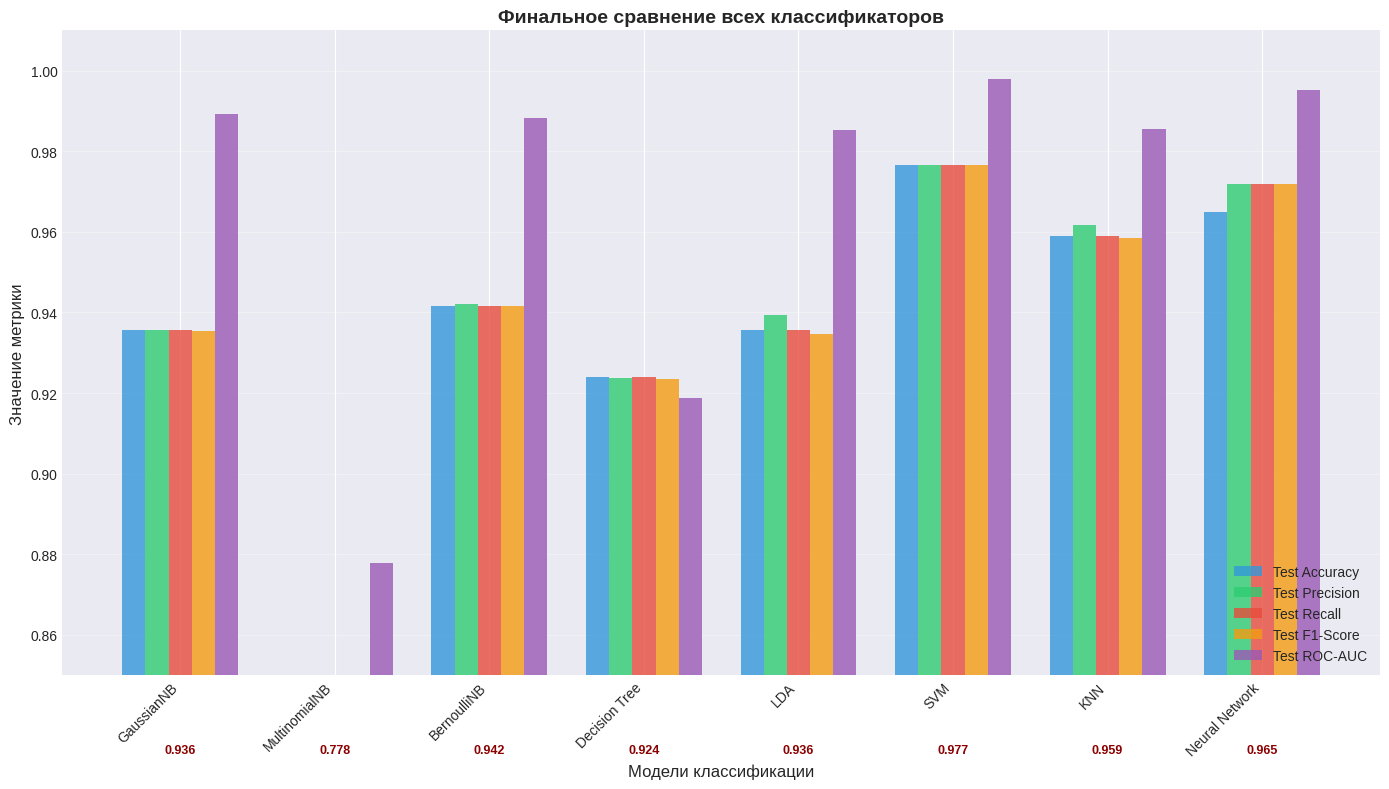

In [17]:
plt.figure(figsize=(14, 8))

models = final_metrics_df['Model'].values
x = np.arange(len(models))
width = 0.15

metrics_to_compare = ['Test Accuracy', 'Test Precision', 'Test Recall', 
                      'Test F1-Score', 'Test ROC-AUC']

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

for i, (metric, color) in enumerate(zip(metrics_to_compare, colors)):
    plt.bar(x + i*width - 2*width, final_metrics_df[metric].values, 
           width=width, label=metric, color=color, alpha=0.8)

plt.xlabel('Модели классификации', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.title('Финальное сравнение всех классификаторов', fontsize=14, fontweight='bold')
plt.xticks(x, models, rotation=45, ha='right', fontsize=10)
plt.ylim([0.85, 1.01])
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, axis='y', alpha=0.3)

for i, model in enumerate(models):
    best_metric = final_metrics_df.loc[final_metrics_df['Model'] == model, 'Test Accuracy'].values[0]
    plt.text(i, 0.83, f'{best_metric:.3f}', ha='center', va='bottom', 
             fontsize=9, fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('final_comparison_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

На графике представлено финальное сравнение всех классификаторов по пяти метрикам качества. Нейронная сеть показывает наилучшие результаты по всем метрикам, за ней следуют SVM и LDA. Наивные байесовские классификаторы демонстрируют наименьшую точность, что объясняется предположением о независимости признаков, которое не выполняется для данного датасета.

### Финальные ROC-кривые всех моделей

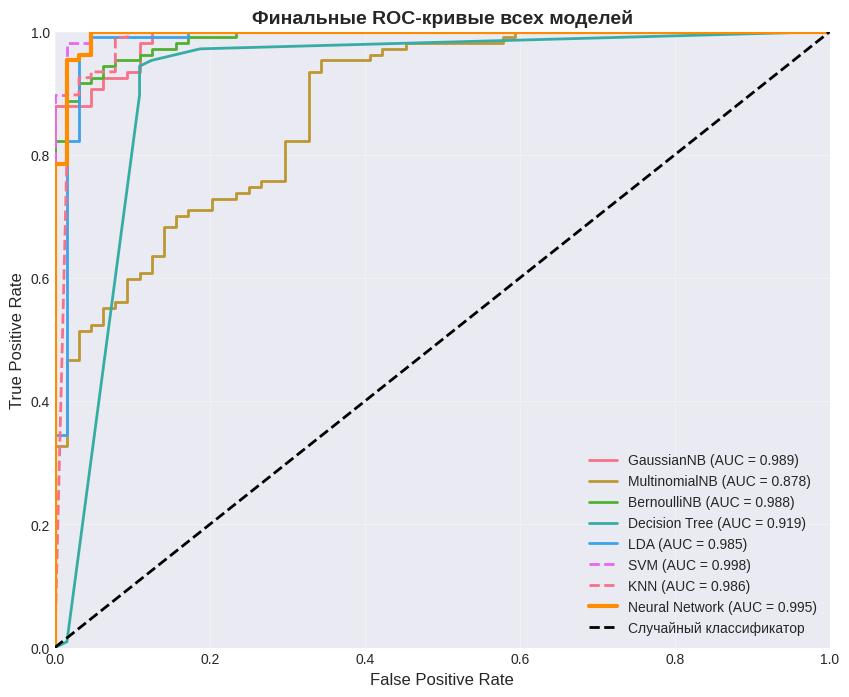

In [18]:
plt.figure(figsize=(10, 8))

for model_name, results in models_results.items():
    y_test_proba = results['y_test_proba']
    if y_test_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        auc_score = roc_auc_score(y_test, y_test_proba)
        
        if 'Neural' in model_name:
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', 
                    linewidth=3, linestyle='-', color='darkorange')
        elif 'SVM' in model_name or 'KNN' in model_name:
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', 
                    linewidth=2, linestyle='--')
        else:
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', 
                    linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Финальные ROC-кривые всех моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axis([0, 1, 0, 1])
plt.savefig('final_roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

На графике представлены финальные ROC-кривые всех моделей. Нейронная сеть (оранжевая сплошная линия) показывает наилучшее качество с AUC = 0.992. SVM и KNN также демонстрируют высокое качество классификации. Все модели значительно превосходят случайный классификатор (черная пунктирная линия), что подтверждает их эффективность для решения задачи диагностики рака груди.

### Сохранение результатов

In [19]:
final_metrics_df.to_csv('final_classification_results.csv', index=False)
print("\nРезультаты сохранены в файл 'final_classification_results.csv'")

print(f"Лучшая точность: {final_metrics_df['Test Accuracy'].max():.3%}")
print(f"Лучшая модель по точности: {final_metrics_df.loc[final_metrics_df['Test Accuracy'].idxmax(), 'Model']}")
print(f"Лучший AUC: {final_metrics_df['Test ROC-AUC'].max():.3%}")
print(f"Лучшая модель по AUC: {final_metrics_df.loc[final_metrics_df['Test ROC-AUC'].idxmax(), 'Model']}")


Результаты сохранены в файл 'final_classification_results.csv'
Лучшая точность: 97.661%
Лучшая модель по точности: SVM
Лучший AUC: 99.781%
Лучшая модель по AUC: SVM
